In [1]:
# 自然语言编码转换
import codecs
import functools
# zip压缩与解压缩
import os
import time
import zipfile
import readdataOneModel as rd
from vocab import Vocab
from tree import Tree
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_fold as td
import sys
from dbOneModel import select
sys.setrecursionlimit(10000000)
data_dir = 'data/'

In [2]:
# 队列读取tfrecord文件中的树结构
def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example, features={'tree': tf.FixedLenFeature([], tf.string),})
    tree = features['tree']
    return tree

In [3]:
#print len(data_set)
vocab = Vocab('../oneModelVocabulary/vocabulary.txt')
#embedding_path = os.path.join(data_dir,'vectors.txt')

In [4]:
def fun(x,y):
    if x.depth() > y.depth():
        return 1
    if x.depth() == y.depth():
        return 0
    else:
        return -1     

In [5]:
def load_embeddings(embedding_path):
    print "Loading word embeding from %s" % embedding_path
    weight_vectors = []
    #word_idx = {}
    with codecs.open(embedding_path, encoding='utf-8') as f:
        # 读取embed文件，建立矩阵和字典
        for i,line in enumerate(f):
            #print(line)
            word, vec = line.split(u' ',1)
            #word_idx[word] = len(weight_vectors)
            weight_vectors.append(np.array(vec.split(), dtype=np.float32))
            if i%10000 == 0:
                print "%d lines have completed" % i
    # 针对字典中未查询到的词，添加对应的随机向量
    weight_vectors.append(np.random.uniform(-0.05,0.05,weight_vectors[0].shape).astype(np.float32))
    return np.stack(weight_vectors)

In [6]:
# 这里初始化embed层矩阵
start = time.time()

with open('12-25-embedding.txt','rb') as f:
    weight_matrix = pickle.load(f)
    
print("aaa")

aaa


In [7]:
def data_input(data_set,train,dev):
    train_data = data_set[:int(len(data_set)*train)]
    dev_data = data_set[int(len(data_set)*train):int(len(data_set)*(train+dev))]
    test_data = data_set[int(len(data_set)*(train+dev)):]
    return train_data,dev_data,test_data

In [8]:
def block_info(block):
    print("%s: %s -> %s" % (block,block.input_type,block.output_type))

In [9]:
# 改写原始LSTM结构，使其支持动态数量的state输入
class ChildSumTreeLSTM(tf.contrib.rnn.BasicLSTMCell):
    
    def __init__(self,mem_dim,keep_prob = 1.0):
        super(ChildSumTreeLSTM,self).__init__(mem_dim)
        #self.in_dim = in_dim
        self.mem_dim = mem_dim
        #self.out_dim = out_dim
        self._keep_prob = keep_prob
    
    def __call__(self,inputs,state,scope=None):
        with tf.variable_scope(scope or type(self).__name__):
            child_state = state
            #print "############################################"
            #print "len(child_state):",len(child_state)
            #print "state : ",child_state
            # 下面分步骤执行tf.concat([inputs,h0,h1,h2...hn],1)
            com = [hi for ci,hi in child_state]
            com.insert(0,inputs)
            #mem = tf.concat(com,1)
            #print("mem.shape: ",mem.get_shape())
            
            concat = tf.contrib.layers.linear(tf.concat(com,1)
                                              ,(len(child_state)+3)*self._num_units)
            splits = tf.split(value=concat,num_or_size_splits=(len(child_state)+3),axis=1)
            i = splits[0]
            j = splits[1]
            o = splits[-1]
            f = splits[2:-1]
            # j是输出门的值，需要执行tanh函数变化，此时self._activation是tanh
            j = self._activation(j)
            if not isinstance(self._keep_prob, float) or self._keep_prob < 1:
                j = tf.nn.dropout(j,self._keep_prob)
            #print("f0: ",f[0])
            one = child_state[0][0]*tf.sigmoid(f[0]+self._forget_bias)
            #print "f-len: ",len(f)
            for k in range(len(f)):
                # 0代表c
                one += child_state[k][0]*tf.sigmoid(f[k]+self._forget_bias)
            
            new_c = one+tf.sigmoid(i)*j
            
            new_h = self._activation(new_c)*tf.sigmoid(o)
            
            new_state = tf.contrib.rnn.LSTMStateTuple(new_c,new_h)
            
        return new_h, new_state

In [10]:
def create_embedding(weight_matrix):
    return td.Embedding(*weight_matrix.shape, initializer=weight_matrix, name='word_embedding')

In [11]:
def create_model(word_embedding,NUM_CLASS,lstm_num_units=300,keep_prob=1,vocab=vocab,reuse=False):
    
    # 建立treelstm隐藏层,这里的lstm单元有300维
    tree_lstm1 = td.ScopedLayer(
            tf.contrib.rnn.DropoutWrapper(
                ChildSumTreeLSTM(lstm_num_units, keep_prob=keep_prob),
                input_keep_prob=keep_prob,output_keep_prob=keep_prob),
            name_or_scope='tree_lstm1')

    tree_lstm2 = td.ScopedLayer(
            tf.contrib.rnn.DropoutWrapper(
                ChildSumTreeLSTM(lstm_num_units, keep_prob=keep_prob),
                input_keep_prob=keep_prob,output_keep_prob=keep_prob),
            name_or_scope='tree_lstm2')

    tree_lstm3 = td.ScopedLayer(
            tf.contrib.rnn.DropoutWrapper(
                ChildSumTreeLSTM(lstm_num_units, keep_prob=keep_prob),
                input_keep_prob=keep_prob,output_keep_prob=keep_prob),
            name_or_scope='tree_lstm3')

    tree_lstm4 = td.ScopedLayer(
            tf.contrib.rnn.DropoutWrapper(
                ChildSumTreeLSTM(lstm_num_units, keep_prob=keep_prob),
                input_keep_prob=keep_prob,output_keep_prob=keep_prob),
            name_or_scope='tree_lstm4')

    tree_lstm5 = td.ScopedLayer(
            tf.contrib.rnn.DropoutWrapper(
                ChildSumTreeLSTM(lstm_num_units, keep_prob=keep_prob),
                input_keep_prob=keep_prob,output_keep_prob=keep_prob),
            name_or_scope='tree_lstm5')
    tree_lstm6 = td.ScopedLayer(
            tf.contrib.rnn.DropoutWrapper(
                ChildSumTreeLSTM(lstm_num_units, keep_prob=keep_prob),
                input_keep_prob=keep_prob,output_keep_prob=keep_prob),
            name_or_scope='tree_lstm6')

    # 建立输出层,NUM_CLASS决定输出类别数
    output_layer = td.FC(NUM_CLASS, activation=None, name='output_layer')   
    
    sub_cut = td.ForwardDeclaration(name="sub_cut")
    
    def lookup_word(word):
        return vocab.index(word)
    
    # 计算tree-lstm中(logit,state)的函数
    # 传入的参数格式是[root.vector,[child_1,child_2,child_3...]] ---- 父亲节点
    # 另一种参数格式是[root.vector] ---- 叶子节点
    def logit_and_state():

        # 获得树结构的长度，1代表叶子节点，大于1则说明是父节点
        def get_length(root):
            length = len(root)
            if length > 1:
                length = 1 + len(root[1])
            #print 'The length: %d' % length
            return length

        word2vec = td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        zeros_state = td.Zeros((tree_lstm1.state_size,)*2,name='zeros_state')        
        word_case = td.AllOf(word2vec,zeros_state,name='word_case') >> tree_lstm2

        # 声明迭代的block，每一个sub_cut()生成一个新的block并传入孩子节点
        pair2vec1 = (sub_cut(),) 
        pair2vec2 = (sub_cut(),sub_cut())
        pair2vec3 = (sub_cut(),sub_cut(),sub_cut())
        pair2vec4 = (sub_cut(),sub_cut(),sub_cut(),sub_cut())
        pair2vec5 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut())
        pair2vec6 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut())
        #pair2vec7 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut()) 
        #pair2vec8 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut()) 
        #pair2vec9 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut())
        #pair2vec10 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut()) 
        #pair2vec11 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),
        #              sub_cut()) 
        #pair2vec12 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),
        #              sub_cut(),sub_cut())   
        #pair2vec13 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),
        #              sub_cut(),sub_cut(),sub_cut())
        #pair2vec14 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),
        #              sub_cut(),sub_cut(),sub_cut(),sub_cut())
        #pair2vec15 = (sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut(),
        #              sub_cut(),sub_cut(),sub_cut(),sub_cut(),sub_cut())   
        # 获取当前节点vector，并且把孩子节点传入sub_cut()
        pair_case1 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
                              ,td.GetItem(1)>>pair2vec1,name='pair_case1') >> tree_lstm1
        pair_case2 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
                              ,td.GetItem(1)>>pair2vec2,name='pair_case2') >> tree_lstm2  
        pair_case3 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
                              ,td.GetItem(1)>>pair2vec3,name='pair_case3') >> tree_lstm3
        pair_case4 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
                              ,td.GetItem(1)>>pair2vec4,name='pair_case4') >> tree_lstm4
        pair_case5 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
                              ,td.GetItem(1)>>pair2vec5,name='pair_case5') >> tree_lstm5
        pair_case6 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
                              ,td.GetItem(1)>>pair2vec6,name='pair_case6') >> tree_lstm6
        #pair_case7 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec7,name='pair_case7') >> tree_lstm7  
        #pair_case8 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec8,name='pair_case8') >> tree_lstm8
        #pair_case9 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec9,name='pair_case9') >> tree_lstm9
        #pair_case10 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec10,name='pair_case10') >> tree_lstm10
        #pair_case11 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec11,name='pair_case11') >> tree_lstm11
        #pair_case12 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec12,name='pair_case12') >> tree_lstm12  
        #pair_case13 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec13,name='pair_case13') >> tree_lstm13
        #pair_case14 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec14,name='pair_case14') >> tree_lstm14
        #pair_case15 = td.AllOf(td.GetItem(0) >> td.InputTransform(lookup_word) >> td.Scalar('int32') >> word_embedding
        #                      ,td.GetItem(1)>>pair2vec15,name='pair_case15') >> tree_lstm15

        # 树结构的判断语句，根据传入的树结构(父节点/叶子节点)执行对应的递归block
        ans = td.OneOf(get_length,[(1,word_case),(2,pair_case1),(3,pair_case2),
                                   (4,pair_case3),(5,pair_case4),(6,pair_case5),
                                   (7,pair_case6)],name='ans')

        # 最终输出是(logits,states)
        last = ans >> (output_layer,td.Identity())
        return last

    # 定义模型以及递归函数
    model = emb_tree(logit_and_state(),is_root=True)
    sub_cut.resolve_to(emb_tree(logit_and_state(),is_root=False))

#    print "mode #############################################"
#    block_info(model)
#    block_info(sub_cut)
    # 想要显示这里就需要加上print
    print("Create completed!")
    
    #input_tree = tf.placeholder(dtype=tf.string,name='input_tree')
    #input_tree
    
    
    compiler = td.Compiler.create(model)
#    print('input type: %s' % model.input_type)
#    print('output type: %s' % model.output_type)
    
    metrics = {k: tf.reduce_mean(v) for k,v in compiler.metric_tensors.items()}
    metrics
    
    return compiler,metrics




In [12]:
# 递归执行函数，model和递归sub_cut()均会编译这一部分，is_root规定了该点是否是根节点
def emb_tree(logit_and_state,is_root):
    # 判断为根节点时会分离出label，之后的递归会设定为非根节点而执行else语句
    if is_root == True:
        return td.InputTransform(cut_tree_and_get_label) >> (td.Scalar('int32'),logit_and_state) >> addmetric()
    else:
        return td.InputTransform(cut_tree) >> logit_and_state >> addmetric2()
# 对非根节点的节点裁剪，输出格式为[[tree.vector],[child_1,child_2...]] ---- 父节点
# 如果该节点是叶子节点，输出格式为[[tree.vector]] ---- 叶子节点
def cut_tree(tree):
    current = [tree.word]
    if (tree.num_children) > 0:
        current.append(tree.children)
    #print "current: ",current
    return current

# 对有label的数据进行裁剪，输出格式为(label,[tree.vector,[child_1,child_2...]])
def cut_tree_and_get_label(label_and_tree):
    #label = label_and_tree[0]
    tree = label_and_tree
    label = tree.gold_label
    current = [tree.word]
    if(tree.num_children) > 0:
        current.append(tree.children)
    #print 'The label: %d, The current: %s' % (label,current)
    return label,current

# 这里是对根节点的数据计算，包括了传递state和loss函数的统计
def addmetric():
    c = td.Composition()
    with c.scope():
        # 这里input是一个(label,(logit,state))格式的输入
        labels = c.input[0]
        logits = td.GetItem(0).reads(c.input[1])
        state = td.GetItem(1).reads(c.input[1])
        
        # 计算loss函数
        loss = td.Function(tf_node_loss)
        td.Metric('root_loss').reads(loss.reads(logits,labels))
        
        # 计算击中率(fine-grained hit)
        hits = td.Function(tf_fine_grained_hits)
        td.Metric('root_hits').reads(hits.reads(logits,labels))
        
        # 这里输出分类logits和state
        c.output.reads(loss,hits,logits,state)
    return c       

# 这里只传递计算出来的孩子state
def addmetric2():
    c = td.Composition()
    with c.scope():
        #logit = td.GetItem(0).reads(c.input)
        state = td.GetItem(1).reads(c.input)
        
        c.output.reads(state)
    return c



In [13]:
# 对预测结果和实际结果计算cross_entropy
def tf_node_loss(logits, labels):
    #labels_one_hot = tf.reshape(labels,logits.get_shape())
    return tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels)

# 对预测结果取整计算击中率(正确为1，错误为0)
def tf_fine_grained_hits(logits, labels):
    # 找到分类中类别最大的，和label对比，计算击中率，类别以0起始
    prediction = tf.cast(tf.argmax(logits,1),tf.int32)
#    labels_oneof_to_one = tf.cast(tf.argmax(labels,1),tf.int32)
    return tf.cast(tf.equal(prediction, labels),tf.float64)

In [14]:
def train_step(epo,num,batch):
    start = time.time()
    train_feed_dict[compiler.loom_input_tensor] = batch
    _,batch_loss = sess.run([train,loss],train_feed_dict)
    end = time.time()
    print('batch %d---%d, batch_loss: %.3e, time: %f' % (epo+1, num, batch_loss, end-start))
    #if num%200 == 0:
    #    checkpoint_path = saver.save(sess, save_path, global_step = epo)
    #    print('model saved in file: %s' % checkpoint_path)        
    return batch_loss

# 统计该epoch下每一个batch的loss之和
def train_epoch(epo,train_set):
    return sum(train_step(epo,num,batch) for num,batch in enumerate(td.group_by_batches(train_set,batch_size),1))

In [15]:
def dev_step(batch):
    #dev_feed_dict[compiler.loom_input_tensor] = batch
    #print batch
    model_output = sess.run(compiler.output_tensors,compiler.build_feed_dict(batch))
    dev_loss_batch = model_output[0]
    dev_hits_batch = model_output[1]
    #print(dev_loss_batch,dev_hits_batch)
    return dev_loss_batch,dev_hits_batch

def dev_eval(epoch,train_loss,dev_set):
    batches = []
    for i in range(len(dev_set)//batch_size):
        start = i*batch_size
        end = min(len(dev_set),(i+1)*batch_size)
        batches.append(dev_set[start:end])
    print 'len dev:',len(batches)
    dev_loss = 0.0
    dev_hits = 0.0
    num_hits = 0
    for batch in batches:
        dev_loss_batch,dev_hits_batch = dev_step(batch)
        dev_loss += sum(dev_loss_batch)
        num_hits += len(dev_hits_batch)
        dev_hits += sum(dev_hits_batch)       
    dev_hits_value = dev_hits/num_hits
    print ('epoch: %4d, train_loss: %.3e, dev_loss_avg: %.3e, dev_accuracy: %.2f' 
    % (epoch, train_loss, dev_loss, dev_hits_value))
    return dev_hits_value

In [16]:
# 多gpu并行训练
tf.reset_default_graph()
num_gpus = 4
batch_size = 128
batch_size2 = batch_size * num_gpus
#learning_rate = 0.01
lr = 0.05
keep_prob_now = 0.75
epoch = 10
embedding_learning_rate_factor = 0.1
save_path = 'multi/Zhao.class_model'

In [17]:
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        
        grads = [g for g,_ in grad_and_vars]
        grad = tf.stack(grads,0)
        grad = tf.reduce_mean(grad,0)
        
        v = grad_and_vars[0][1]
        grad_and_var = (grad,v)
        average_grads.append(grad_and_var)
    return average_grads

In [18]:
def feed_all_gpu(inp_dict,models,payload_per_gpu,batch):
    for i in range(len(models)):
        input_tensor = models[i][0]
        start_pos = i * payload_per_gpu
        stop_pos = (i + 1) * payload_per_gpu
        inp_dict[input_tensor] = batch[start_pos:stop_pos]
    return inp_dict

In [19]:
def train_step2(models,epo,num,batch,train_feed_dict,train_op,aver_loss_op):
    start = time.time()
    
    payload_per_gpu = len(batch)/num_gpus
    train_feed_dict = feed_all_gpu(train_feed_dict,models,payload_per_gpu,batch)
    
    #train_feed_dict[compiler.loom_input_tensor] = batch
    _,batch_loss = sess.run([train_op,aver_loss_op],train_feed_dict)
    end = time.time()
    
    print('batch %d---%d, batch_size: %d, batch_loss: %.3e, time: %f' % (epo+1, num, len(batch), batch_loss, end-start))
    #if num%200 == 0:
    #    checkpoint_path = saver.save(sess, save_path, global_step = epo)
    #    print('model saved in file: %s' % checkpoint_path)        
    return batch_loss

# 统计该epoch下每一个batch的loss之和
def train_epoch2(epo,train_set,models,train_feed_dict,train_op,aver_loss_op):
    return sum(train_step2(models,epo,num,batch,train_feed_dict,train_op,aver_loss_op) for num,batch in enumerate(td.group_by_batches(train_set,batch_size2),1))

tf.Tensor 'output_gathers/float32___TensorFlowFoldOutputTag_0:0' shape=(?,) dtype=float32  loss

tf.Tensor 'output_gathers/float64___TensorFlowFoldOutputTag_1:0' shape=(?,) dtype=float64  hits

tf.Tensor 'output_gathers/float32_42237__TensorFlowFoldOutputTag_2:0' shape=(?, 42237) dtype=float32  logits

tf.Tensor 'output_gathers/float32_150__TensorFlowFoldOutputTag_3:0' shape=(?, 150) dtype=float32  hidden

tf.Tensor 'output_gathers/float32_150__TensorFlowFoldOutputTag_4:0' shape=(?, 150) dtype=float32  state

In [21]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as sess:
    word_embedding = create_embedding(weight_matrix=weight_matrix)
    compiler, metrics = create_model(word_embedding=word_embedding,NUM_CLASS=14537,lstm_num_units=300,keep_prob=keep_prob_now,vocab=vocab)
    with tf.device('/cpu:0'):
        
        train_feed_dict = {}
        keep_prob_ph = tf.placeholder_with_default(1.0,[])
        train_feed_dict = {keep_prob_ph:keep_prob_now}
               
        learning_rate = tf.placeholder(tf.float32,shape=[])
        opt = tf.train.AdagradOptimizer(learning_rate=learning_rate)
        
        print('build model...')
        print('build model on gpu tower...')
        models = []
        for gpu_id in range(num_gpus):
            with tf.device('/gpu:%d' % gpu_id):
                print('tower:%d...' % gpu_id)
                with tf.name_scope('tower_%d' % gpu_id):
                    with tf.variable_scope('cpu_variables'):
                        compilergpu = compiler
                        
                        input_tensor = compilergpu.loom_input_tensor
                        loss = tf.reduce_mean(compilergpu.output_tensors[0])
                        pred = compilergpu.output_tensors[2]
                        grads_and_vars = opt.compute_gradients(loss)
                        
                        capped_gradients = [(tf.clip_by_value(grad,-1.,1.),var) for grad,var in grads_and_vars if grad is not None]
                        #print(grads_and_vars)
                        # 训练embedding层时，弱化bp时候的梯度
                        found = 0
                        for i,(grad,var) in enumerate(capped_gradients):
                            if var == word_embedding.weights:
                                found+=1
                                grad = tf.scalar_mul(embedding_learning_rate_factor,grad)
                                capped_gradients[i] = (grad,var)
                        assert found == 1                                       
                        
                        capped_gradients = capped_gradients[-15:]
                        #print(len(grads_and_vars))
                        models.append((input_tensor,pred,loss,capped_gradients))
                        
        saver = tf.train.Saver()
        
        print('build model on gpu tower done.')
        
        print('reduce model on cpu...')
        tower_input_tensors,tower_pred,tower_losses,tower_grads = zip(*models)
        
        apply_gradient_op = opt.apply_gradients(average_gradients(tower_grads))
        aver_loss_op = tf.reduce_mean(tower_losses)
        
        print('training the model')
        sess.run(tf.global_variables_initializer())
        for epo in range(epoch):
            for num in range(5):
                print('read data_set_%s' % (num+1))
                read_start = time.time()
                
                dataset_temp = select(num*600000,600000)
                np.random.shuffle(dataset_temp)
                
                print('completed read data_set_%s, time: %.4f' % (num+1,time.time()-read_start))
                
                train_data_epo,dev_data_temp,_ = data_input(dataset_temp,1.0,0.0)
                
                # 读读取的数据进行排序（不推荐）
#                 print('start epo_%d_%d sort' % (epo+1,num+1))
#                 sort_start = time.time()
#                 train_data_epo = sorted(train_data_epo,fun)
#                 print('sort time: %.4f' % (time.time()-sort_start))    
                
                train_data_epo_for_shuffled = compiler.build_loom_inputs(train_data_epo)
                   
                start = time.time()
                
                train_feed_dict[learning_rate] = lr
                for shuffled in td.epochs(train_data_epo_for_shuffled,1):                    
                    train_loss = train_epoch2(num,shuffled,models,train_feed_dict,apply_gradient_op,aver_loss_op)
        
                end = time.time()
                train_data_epo = []
                dev_data_temp = []
                train_data_epo_for_shuffled = None
                print('epo:%4d--%d, time:%f' % (epo+1,num+1,end-start))       
            checkpoint_path = saver.save(sess, save_path, global_step = epo)
            print('model saved in file: %s' % checkpoint_path) 

# 跑到这里                

Create completed!
build model...
build model on gpu tower...
tower:0...
tower:1...
tower:2...
tower:3...
build model on gpu tower done.
reduce model on cpu...
training the model
read data_set_1
completed read data_set_1, time: 274.0777
batch 1---1, batch_size: 512, batch_loss: 9.586e+00, time: 10.179702
batch 1---2, batch_size: 512, batch_loss: 9.446e+00, time: 4.102390
batch 1---3, batch_size: 512, batch_loss: 9.359e+00, time: 7.945538
batch 1---4, batch_size: 512, batch_loss: 9.265e+00, time: 5.589755
batch 1---5, batch_size: 512, batch_loss: 9.295e+00, time: 4.063372
batch 1---6, batch_size: 512, batch_loss: 9.299e+00, time: 7.098470
batch 1---7, batch_size: 512, batch_loss: 9.099e+00, time: 6.754874
batch 1---8, batch_size: 512, batch_loss: 8.965e+00, time: 6.631156
batch 1---9, batch_size: 512, batch_loss: 9.002e+00, time: 8.247851
batch 1---10, batch_size: 512, batch_loss: 8.892e+00, time: 4.688923
batch 1---11, batch_size: 512, batch_loss: 8.883e+00, time: 4.592670
batch 1---12,

batch 1---117, batch_size: 512, batch_loss: 6.295e+00, time: 5.437510
batch 1---118, batch_size: 512, batch_loss: 6.201e+00, time: 4.791862
batch 1---119, batch_size: 512, batch_loss: 6.307e+00, time: 8.087879
batch 1---120, batch_size: 512, batch_loss: 6.362e+00, time: 6.002090
batch 1---121, batch_size: 512, batch_loss: 6.671e+00, time: 6.728531
batch 1---122, batch_size: 512, batch_loss: 6.232e+00, time: 5.565589
batch 1---123, batch_size: 512, batch_loss: 6.355e+00, time: 7.836183
batch 1---124, batch_size: 512, batch_loss: 6.366e+00, time: 6.217630
batch 1---125, batch_size: 512, batch_loss: 6.307e+00, time: 3.134249
batch 1---126, batch_size: 512, batch_loss: 6.549e+00, time: 6.676247
batch 1---127, batch_size: 512, batch_loss: 6.376e+00, time: 9.952556
batch 1---128, batch_size: 512, batch_loss: 6.892e+00, time: 3.548156
batch 1---129, batch_size: 512, batch_loss: 6.443e+00, time: 3.840429
batch 1---130, batch_size: 512, batch_loss: 7.157e+00, time: 5.936107
batch 1---131, batch

batch 1---235, batch_size: 512, batch_loss: 6.686e+00, time: 4.742424
batch 1---236, batch_size: 512, batch_loss: 6.622e+00, time: 6.516468
batch 1---237, batch_size: 512, batch_loss: 6.592e+00, time: 7.852911
batch 1---238, batch_size: 512, batch_loss: 6.234e+00, time: 5.614898
batch 1---239, batch_size: 512, batch_loss: 6.309e+00, time: 3.756508
batch 1---240, batch_size: 512, batch_loss: 6.364e+00, time: 7.884733
batch 1---241, batch_size: 512, batch_loss: 5.840e+00, time: 6.107748
batch 1---242, batch_size: 512, batch_loss: 5.762e+00, time: 4.663043
batch 1---243, batch_size: 512, batch_loss: 5.553e+00, time: 3.648395
batch 1---244, batch_size: 512, batch_loss: 6.287e+00, time: 7.121013
batch 1---245, batch_size: 512, batch_loss: 6.553e+00, time: 9.568293
batch 1---246, batch_size: 512, batch_loss: 5.890e+00, time: 9.746151
batch 1---247, batch_size: 512, batch_loss: 6.460e+00, time: 3.788112
batch 1---248, batch_size: 512, batch_loss: 6.325e+00, time: 8.424390
batch 1---249, batch

batch 1---353, batch_size: 512, batch_loss: 5.809e+00, time: 7.361759
batch 1---354, batch_size: 512, batch_loss: 6.137e+00, time: 6.662931
batch 1---355, batch_size: 512, batch_loss: 5.888e+00, time: 9.573637
batch 1---356, batch_size: 512, batch_loss: 5.557e+00, time: 7.059892
batch 1---357, batch_size: 512, batch_loss: 5.643e+00, time: 9.462667
batch 1---358, batch_size: 512, batch_loss: 5.911e+00, time: 6.873908
batch 1---359, batch_size: 512, batch_loss: 6.096e+00, time: 8.417213
batch 1---360, batch_size: 512, batch_loss: 6.076e+00, time: 3.691748
batch 1---361, batch_size: 512, batch_loss: 5.889e+00, time: 9.205035
batch 1---362, batch_size: 512, batch_loss: 5.898e+00, time: 9.618275
batch 1---363, batch_size: 512, batch_loss: 6.013e+00, time: 4.123255
batch 1---364, batch_size: 512, batch_loss: 5.871e+00, time: 6.037715
batch 1---365, batch_size: 512, batch_loss: 5.617e+00, time: 8.047691
batch 1---366, batch_size: 512, batch_loss: 5.643e+00, time: 5.171815
batch 1---367, batch

batch 1---471, batch_size: 512, batch_loss: 5.695e+00, time: 4.494300
batch 1---472, batch_size: 512, batch_loss: 6.077e+00, time: 4.533404
batch 1---473, batch_size: 512, batch_loss: 5.698e+00, time: 4.109339
batch 1---474, batch_size: 512, batch_loss: 5.738e+00, time: 6.864378
batch 1---475, batch_size: 512, batch_loss: 5.737e+00, time: 4.474360
batch 1---476, batch_size: 512, batch_loss: 5.540e+00, time: 9.628158
batch 1---477, batch_size: 512, batch_loss: 5.767e+00, time: 7.082438
batch 1---478, batch_size: 512, batch_loss: 5.551e+00, time: 6.262893
batch 1---479, batch_size: 512, batch_loss: 5.705e+00, time: 6.300162
batch 1---480, batch_size: 512, batch_loss: 5.951e+00, time: 8.240068
batch 1---481, batch_size: 512, batch_loss: 5.687e+00, time: 4.619395
batch 1---482, batch_size: 512, batch_loss: 5.826e+00, time: 8.932410
batch 1---483, batch_size: 512, batch_loss: 5.952e+00, time: 4.833659
batch 1---484, batch_size: 512, batch_loss: 5.669e+00, time: 7.770389
batch 1---485, batch

batch 1---589, batch_size: 512, batch_loss: 5.680e+00, time: 7.289296
batch 1---590, batch_size: 512, batch_loss: 5.714e+00, time: 6.600996
batch 1---591, batch_size: 512, batch_loss: 5.536e+00, time: 4.760544
batch 1---592, batch_size: 512, batch_loss: 5.939e+00, time: 7.704318
batch 1---593, batch_size: 512, batch_loss: 5.551e+00, time: 7.605547
batch 1---594, batch_size: 512, batch_loss: 5.668e+00, time: 5.098740
batch 1---595, batch_size: 512, batch_loss: 5.553e+00, time: 6.094946
batch 1---596, batch_size: 512, batch_loss: 6.063e+00, time: 4.201866
batch 1---597, batch_size: 512, batch_loss: 5.530e+00, time: 7.894173
batch 1---598, batch_size: 512, batch_loss: 5.580e+00, time: 9.312876
batch 1---599, batch_size: 512, batch_loss: 5.328e+00, time: 6.708913
batch 1---600, batch_size: 512, batch_loss: 5.821e+00, time: 8.483275
batch 1---601, batch_size: 512, batch_loss: 5.962e+00, time: 7.455034
batch 1---602, batch_size: 512, batch_loss: 5.385e+00, time: 7.539053
batch 1---603, batch

batch 1---707, batch_size: 512, batch_loss: 5.307e+00, time: 5.850747
batch 1---708, batch_size: 512, batch_loss: 5.985e+00, time: 6.198597
batch 1---709, batch_size: 512, batch_loss: 5.401e+00, time: 3.296576
batch 1---710, batch_size: 512, batch_loss: 5.432e+00, time: 8.040952
batch 1---711, batch_size: 512, batch_loss: 6.066e+00, time: 9.877024
batch 1---712, batch_size: 512, batch_loss: 5.910e+00, time: 9.677649
batch 1---713, batch_size: 512, batch_loss: 5.801e+00, time: 7.379986
batch 1---714, batch_size: 512, batch_loss: 5.491e+00, time: 5.908368
batch 1---715, batch_size: 512, batch_loss: 5.540e+00, time: 11.262861
batch 1---716, batch_size: 512, batch_loss: 5.934e+00, time: 9.428496
batch 1---717, batch_size: 512, batch_loss: 5.195e+00, time: 7.048721
batch 1---718, batch_size: 512, batch_loss: 5.447e+00, time: 7.718806
batch 1---719, batch_size: 512, batch_loss: 5.721e+00, time: 6.741249
batch 1---720, batch_size: 512, batch_loss: 5.597e+00, time: 9.426062
batch 1---721, batc

batch 1---825, batch_size: 512, batch_loss: 5.043e+00, time: 8.388714
batch 1---826, batch_size: 512, batch_loss: 6.017e+00, time: 6.108067
batch 1---827, batch_size: 512, batch_loss: 5.409e+00, time: 4.046179
batch 1---828, batch_size: 512, batch_loss: 5.851e+00, time: 4.838937
batch 1---829, batch_size: 512, batch_loss: 5.302e+00, time: 4.810662
batch 1---830, batch_size: 512, batch_loss: 5.628e+00, time: 6.258315
batch 1---831, batch_size: 512, batch_loss: 5.639e+00, time: 4.368528
batch 1---832, batch_size: 512, batch_loss: 5.345e+00, time: 3.878344
batch 1---833, batch_size: 512, batch_loss: 5.475e+00, time: 3.843880
batch 1---834, batch_size: 512, batch_loss: 5.654e+00, time: 9.237426
batch 1---835, batch_size: 512, batch_loss: 5.405e+00, time: 6.130931
batch 1---836, batch_size: 512, batch_loss: 5.239e+00, time: 8.306834
batch 1---837, batch_size: 512, batch_loss: 5.601e+00, time: 6.419320
batch 1---838, batch_size: 512, batch_loss: 5.333e+00, time: 5.130450
batch 1---839, batch

batch 1---943, batch_size: 512, batch_loss: 5.725e+00, time: 6.450966
batch 1---944, batch_size: 512, batch_loss: 5.970e+00, time: 6.951287
batch 1---945, batch_size: 512, batch_loss: 5.385e+00, time: 4.517777
batch 1---946, batch_size: 512, batch_loss: 5.478e+00, time: 6.368590
batch 1---947, batch_size: 512, batch_loss: 5.975e+00, time: 7.824408
batch 1---948, batch_size: 512, batch_loss: 5.548e+00, time: 4.552187
batch 1---949, batch_size: 512, batch_loss: 5.014e+00, time: 7.688919
batch 1---950, batch_size: 512, batch_loss: 5.272e+00, time: 6.504104
batch 1---951, batch_size: 512, batch_loss: 5.362e+00, time: 4.188624
batch 1---952, batch_size: 512, batch_loss: 5.783e+00, time: 6.295875
batch 1---953, batch_size: 512, batch_loss: 5.287e+00, time: 4.475539
batch 1---954, batch_size: 512, batch_loss: 5.489e+00, time: 8.654731
batch 1---955, batch_size: 512, batch_loss: 5.299e+00, time: 4.319215
batch 1---956, batch_size: 512, batch_loss: 5.632e+00, time: 4.504508
batch 1---957, batch

batch 1---1060, batch_size: 512, batch_loss: 5.755e+00, time: 7.608732
batch 1---1061, batch_size: 512, batch_loss: 5.610e+00, time: 9.207500
batch 1---1062, batch_size: 512, batch_loss: 5.718e+00, time: 6.445498
batch 1---1063, batch_size: 512, batch_loss: 5.575e+00, time: 8.135892
batch 1---1064, batch_size: 512, batch_loss: 5.297e+00, time: 9.287089
batch 1---1065, batch_size: 512, batch_loss: 5.450e+00, time: 6.327727
batch 1---1066, batch_size: 512, batch_loss: 4.958e+00, time: 6.454585
batch 1---1067, batch_size: 512, batch_loss: 5.767e+00, time: 4.726982
batch 1---1068, batch_size: 512, batch_loss: 5.124e+00, time: 6.754974
batch 1---1069, batch_size: 512, batch_loss: 5.167e+00, time: 6.939987
batch 1---1070, batch_size: 512, batch_loss: 5.714e+00, time: 5.522187
batch 1---1071, batch_size: 512, batch_loss: 5.703e+00, time: 6.064784
batch 1---1072, batch_size: 512, batch_loss: 5.519e+00, time: 5.219884
batch 1---1073, batch_size: 512, batch_loss: 5.625e+00, time: 3.481354
batch 

batch 2---3, batch_size: 512, batch_loss: 6.092e+00, time: 10.544354
batch 2---4, batch_size: 512, batch_loss: 6.472e+00, time: 9.738595
batch 2---5, batch_size: 512, batch_loss: 5.941e+00, time: 8.912979
batch 2---6, batch_size: 512, batch_loss: 5.852e+00, time: 8.350456
batch 2---7, batch_size: 512, batch_loss: 5.735e+00, time: 5.200045
batch 2---8, batch_size: 512, batch_loss: 5.826e+00, time: 9.431196
batch 2---9, batch_size: 512, batch_loss: 5.996e+00, time: 10.380589
batch 2---10, batch_size: 512, batch_loss: 6.155e+00, time: 7.034204
batch 2---11, batch_size: 512, batch_loss: 5.567e+00, time: 5.804090
batch 2---12, batch_size: 512, batch_loss: 5.986e+00, time: 9.140745
batch 2---13, batch_size: 512, batch_loss: 5.947e+00, time: 11.222780
batch 2---14, batch_size: 512, batch_loss: 6.286e+00, time: 6.824812
batch 2---15, batch_size: 512, batch_loss: 6.256e+00, time: 9.934646
batch 2---16, batch_size: 512, batch_loss: 6.136e+00, time: 7.239874
batch 2---17, batch_size: 512, batch_l

batch 2---122, batch_size: 512, batch_loss: 6.046e+00, time: 11.500515
batch 2---123, batch_size: 512, batch_loss: 5.056e+00, time: 10.451974
batch 2---124, batch_size: 512, batch_loss: 5.499e+00, time: 8.723142
batch 2---125, batch_size: 512, batch_loss: 5.324e+00, time: 8.517302
batch 2---126, batch_size: 512, batch_loss: 5.694e+00, time: 7.538964
batch 2---127, batch_size: 512, batch_loss: 5.370e+00, time: 9.708697
batch 2---128, batch_size: 512, batch_loss: 5.664e+00, time: 7.310768
batch 2---129, batch_size: 512, batch_loss: 5.883e+00, time: 8.934723
batch 2---130, batch_size: 512, batch_loss: 5.580e+00, time: 9.638830
batch 2---131, batch_size: 512, batch_loss: 5.933e+00, time: 10.566998
batch 2---132, batch_size: 512, batch_loss: 5.858e+00, time: 8.246249
batch 2---133, batch_size: 512, batch_loss: 5.556e+00, time: 7.789661
batch 2---134, batch_size: 512, batch_loss: 5.833e+00, time: 9.012932
batch 2---135, batch_size: 512, batch_loss: 5.780e+00, time: 9.413445
batch 2---136, ba

batch 2---239, batch_size: 512, batch_loss: 5.421e+00, time: 8.372361
batch 2---240, batch_size: 512, batch_loss: 6.185e+00, time: 8.433623
batch 2---241, batch_size: 512, batch_loss: 5.393e+00, time: 9.886362
batch 2---242, batch_size: 512, batch_loss: 5.519e+00, time: 9.915795
batch 2---243, batch_size: 512, batch_loss: 5.410e+00, time: 7.861768
batch 2---244, batch_size: 512, batch_loss: 5.541e+00, time: 11.740800
batch 2---245, batch_size: 512, batch_loss: 5.450e+00, time: 8.051774
batch 2---246, batch_size: 512, batch_loss: 4.974e+00, time: 11.463087
batch 2---247, batch_size: 512, batch_loss: 5.210e+00, time: 8.240418
batch 2---248, batch_size: 512, batch_loss: 5.986e+00, time: 6.451311
batch 2---249, batch_size: 512, batch_loss: 5.541e+00, time: 8.335710
batch 2---250, batch_size: 512, batch_loss: 5.628e+00, time: 8.702357
batch 2---251, batch_size: 512, batch_loss: 6.053e+00, time: 9.771499
batch 2---252, batch_size: 512, batch_loss: 5.730e+00, time: 9.038418
batch 2---253, bat

batch 2---356, batch_size: 512, batch_loss: 5.363e+00, time: 10.776898
batch 2---357, batch_size: 512, batch_loss: 5.507e+00, time: 7.137260
batch 2---358, batch_size: 512, batch_loss: 4.891e+00, time: 8.854725
batch 2---359, batch_size: 512, batch_loss: 6.149e+00, time: 8.729355
batch 2---360, batch_size: 512, batch_loss: 5.165e+00, time: 9.965800
batch 2---361, batch_size: 512, batch_loss: 5.422e+00, time: 10.106450
batch 2---362, batch_size: 512, batch_loss: 5.721e+00, time: 4.398312
batch 2---363, batch_size: 512, batch_loss: 6.247e+00, time: 7.604681
batch 2---364, batch_size: 512, batch_loss: 5.631e+00, time: 7.173939
batch 2---365, batch_size: 512, batch_loss: 5.726e+00, time: 9.652929
batch 2---366, batch_size: 512, batch_loss: 5.478e+00, time: 10.365778
batch 2---367, batch_size: 512, batch_loss: 5.652e+00, time: 6.356201
batch 2---368, batch_size: 512, batch_loss: 5.588e+00, time: 11.518502
batch 2---369, batch_size: 512, batch_loss: 5.669e+00, time: 10.282947
batch 2---370, 

batch 2---473, batch_size: 512, batch_loss: 5.438e+00, time: 8.690767
batch 2---474, batch_size: 512, batch_loss: 5.724e+00, time: 7.690922
batch 2---475, batch_size: 512, batch_loss: 5.815e+00, time: 8.909152
batch 2---476, batch_size: 512, batch_loss: 5.520e+00, time: 7.733914
batch 2---477, batch_size: 512, batch_loss: 5.725e+00, time: 9.309433
batch 2---478, batch_size: 512, batch_loss: 5.640e+00, time: 7.058251
batch 2---479, batch_size: 512, batch_loss: 6.058e+00, time: 9.506392
batch 2---480, batch_size: 512, batch_loss: 5.309e+00, time: 6.798172
batch 2---481, batch_size: 512, batch_loss: 5.851e+00, time: 8.390413
batch 2---482, batch_size: 512, batch_loss: 5.682e+00, time: 7.395580
batch 2---483, batch_size: 512, batch_loss: 5.790e+00, time: 10.422613
batch 2---484, batch_size: 512, batch_loss: 5.752e+00, time: 5.740100
batch 2---485, batch_size: 512, batch_loss: 5.838e+00, time: 8.137286
batch 2---486, batch_size: 512, batch_loss: 5.815e+00, time: 11.691788
batch 2---487, bat

batch 2---590, batch_size: 512, batch_loss: 5.569e+00, time: 6.229698
batch 2---591, batch_size: 512, batch_loss: 5.506e+00, time: 6.088858
batch 2---592, batch_size: 512, batch_loss: 5.969e+00, time: 6.053695
batch 2---593, batch_size: 512, batch_loss: 5.280e+00, time: 10.586619
batch 2---594, batch_size: 512, batch_loss: 5.865e+00, time: 6.446349
batch 2---595, batch_size: 512, batch_loss: 5.866e+00, time: 9.257880
batch 2---596, batch_size: 512, batch_loss: 5.630e+00, time: 8.941178
batch 2---597, batch_size: 512, batch_loss: 5.187e+00, time: 6.977030
batch 2---598, batch_size: 512, batch_loss: 5.814e+00, time: 10.094317
batch 2---599, batch_size: 512, batch_loss: 5.520e+00, time: 7.376124
batch 2---600, batch_size: 512, batch_loss: 5.365e+00, time: 8.432220
batch 2---601, batch_size: 512, batch_loss: 5.620e+00, time: 9.706258
batch 2---602, batch_size: 512, batch_loss: 5.465e+00, time: 6.799917
batch 2---603, batch_size: 512, batch_loss: 5.227e+00, time: 6.953151
batch 2---604, bat

batch 2---707, batch_size: 512, batch_loss: 6.243e+00, time: 8.444784
batch 2---708, batch_size: 512, batch_loss: 5.873e+00, time: 8.534627
batch 2---709, batch_size: 512, batch_loss: 6.047e+00, time: 11.377517
batch 2---710, batch_size: 512, batch_loss: 5.245e+00, time: 8.380643
batch 2---711, batch_size: 512, batch_loss: 5.504e+00, time: 7.582214
batch 2---712, batch_size: 512, batch_loss: 5.724e+00, time: 7.917589
batch 2---713, batch_size: 512, batch_loss: 5.454e+00, time: 9.677864
batch 2---714, batch_size: 512, batch_loss: 5.605e+00, time: 9.166500
batch 2---715, batch_size: 512, batch_loss: 5.467e+00, time: 6.718709
batch 2---716, batch_size: 512, batch_loss: 5.535e+00, time: 6.570728
batch 2---717, batch_size: 512, batch_loss: 5.504e+00, time: 6.892642
batch 2---718, batch_size: 512, batch_loss: 5.623e+00, time: 8.192221
batch 2---719, batch_size: 512, batch_loss: 5.459e+00, time: 10.525687
batch 2---720, batch_size: 512, batch_loss: 6.199e+00, time: 6.378057
batch 2---721, bat

batch 2---824, batch_size: 512, batch_loss: 5.681e+00, time: 11.266973
batch 2---825, batch_size: 512, batch_loss: 5.854e+00, time: 9.346248
batch 2---826, batch_size: 512, batch_loss: 5.794e+00, time: 10.069119
batch 2---827, batch_size: 512, batch_loss: 5.807e+00, time: 5.269239
batch 2---828, batch_size: 512, batch_loss: 5.669e+00, time: 7.385089
batch 2---829, batch_size: 512, batch_loss: 5.905e+00, time: 11.146848
batch 2---830, batch_size: 512, batch_loss: 5.658e+00, time: 7.673310
batch 2---831, batch_size: 512, batch_loss: 5.804e+00, time: 8.458076
batch 2---832, batch_size: 512, batch_loss: 5.436e+00, time: 6.944234
batch 2---833, batch_size: 512, batch_loss: 5.575e+00, time: 7.036154
batch 2---834, batch_size: 512, batch_loss: 5.612e+00, time: 5.005843
batch 2---835, batch_size: 512, batch_loss: 5.522e+00, time: 9.368220
batch 2---836, batch_size: 512, batch_loss: 5.105e+00, time: 10.502637
batch 2---837, batch_size: 512, batch_loss: 5.194e+00, time: 10.723585
batch 2---838, 

batch 2---941, batch_size: 512, batch_loss: 5.275e+00, time: 8.491568
batch 2---942, batch_size: 512, batch_loss: 5.646e+00, time: 9.939260
batch 2---943, batch_size: 512, batch_loss: 5.650e+00, time: 11.549913
batch 2---944, batch_size: 512, batch_loss: 5.919e+00, time: 6.174345
batch 2---945, batch_size: 512, batch_loss: 5.377e+00, time: 7.976691
batch 2---946, batch_size: 512, batch_loss: 5.513e+00, time: 10.294073
batch 2---947, batch_size: 512, batch_loss: 5.165e+00, time: 7.141456
batch 2---948, batch_size: 512, batch_loss: 5.698e+00, time: 6.911686
batch 2---949, batch_size: 512, batch_loss: 6.039e+00, time: 9.043079
batch 2---950, batch_size: 512, batch_loss: 5.251e+00, time: 10.292379
batch 2---951, batch_size: 512, batch_loss: 5.299e+00, time: 9.949433
batch 2---952, batch_size: 512, batch_loss: 5.745e+00, time: 7.950266
batch 2---953, batch_size: 512, batch_loss: 5.618e+00, time: 5.892421
batch 2---954, batch_size: 512, batch_loss: 5.172e+00, time: 10.596503
batch 2---955, b

batch 2---1057, batch_size: 512, batch_loss: 5.941e+00, time: 11.167926
batch 2---1058, batch_size: 512, batch_loss: 5.440e+00, time: 8.557931
batch 2---1059, batch_size: 512, batch_loss: 5.596e+00, time: 11.563678
batch 2---1060, batch_size: 512, batch_loss: 5.377e+00, time: 7.055548
batch 2---1061, batch_size: 512, batch_loss: 5.566e+00, time: 7.413672
batch 2---1062, batch_size: 512, batch_loss: 5.509e+00, time: 8.636050
batch 2---1063, batch_size: 512, batch_loss: 5.353e+00, time: 8.843164
batch 2---1064, batch_size: 512, batch_loss: 5.443e+00, time: 10.580452
batch 2---1065, batch_size: 512, batch_loss: 5.695e+00, time: 7.456557
batch 2---1066, batch_size: 512, batch_loss: 5.075e+00, time: 6.608733
batch 2---1067, batch_size: 512, batch_loss: 5.290e+00, time: 10.631559
batch 2---1068, batch_size: 512, batch_loss: 5.423e+00, time: 9.335176
batch 2---1069, batch_size: 512, batch_loss: 5.476e+00, time: 10.076048
batch 2---1070, batch_size: 512, batch_loss: 5.373e+00, time: 6.522147
b

completed read data_set_3, time: 269.7485
batch 3---1, batch_size: 512, batch_loss: 5.459e+00, time: 5.069001
batch 3---2, batch_size: 512, batch_loss: 6.329e+00, time: 10.893657
batch 3---3, batch_size: 512, batch_loss: 5.261e+00, time: 3.974627
batch 3---4, batch_size: 512, batch_loss: 6.495e+00, time: 8.988921
batch 3---5, batch_size: 512, batch_loss: 6.062e+00, time: 10.823230
batch 3---6, batch_size: 512, batch_loss: 5.529e+00, time: 5.806795
batch 3---7, batch_size: 512, batch_loss: 6.152e+00, time: 9.494492
batch 3---8, batch_size: 512, batch_loss: 5.485e+00, time: 8.602474
batch 3---9, batch_size: 512, batch_loss: 5.438e+00, time: 9.574664
batch 3---10, batch_size: 512, batch_loss: 5.457e+00, time: 7.947206
batch 3---11, batch_size: 512, batch_loss: 6.273e+00, time: 10.040770
batch 3---12, batch_size: 512, batch_loss: 5.995e+00, time: 8.812023
batch 3---13, batch_size: 512, batch_loss: 6.119e+00, time: 4.279464
batch 3---14, batch_size: 512, batch_loss: 6.162e+00, time: 5.34866

batch 3---119, batch_size: 512, batch_loss: 6.201e+00, time: 10.902594
batch 3---120, batch_size: 512, batch_loss: 5.214e+00, time: 6.561759
batch 3---121, batch_size: 512, batch_loss: 5.309e+00, time: 4.490854
batch 3---122, batch_size: 512, batch_loss: 5.527e+00, time: 7.736877
batch 3---123, batch_size: 512, batch_loss: 6.045e+00, time: 5.632744
batch 3---124, batch_size: 512, batch_loss: 5.789e+00, time: 5.356019
batch 3---125, batch_size: 512, batch_loss: 5.527e+00, time: 10.059896
batch 3---126, batch_size: 512, batch_loss: 6.105e+00, time: 7.728308
batch 3---127, batch_size: 512, batch_loss: 5.766e+00, time: 5.912215
batch 3---128, batch_size: 512, batch_loss: 6.032e+00, time: 5.980270
batch 3---129, batch_size: 512, batch_loss: 5.964e+00, time: 9.901796
batch 3---130, batch_size: 512, batch_loss: 5.872e+00, time: 11.242007
batch 3---131, batch_size: 512, batch_loss: 5.616e+00, time: 3.714958
batch 3---132, batch_size: 512, batch_loss: 5.740e+00, time: 9.002266
batch 3---133, ba

batch 3---236, batch_size: 512, batch_loss: 6.405e+00, time: 10.752201
batch 3---237, batch_size: 512, batch_loss: 5.934e+00, time: 6.245775
batch 3---238, batch_size: 512, batch_loss: 6.179e+00, time: 9.570810
batch 3---239, batch_size: 512, batch_loss: 5.626e+00, time: 6.324775
batch 3---240, batch_size: 512, batch_loss: 5.449e+00, time: 4.597587
batch 3---241, batch_size: 512, batch_loss: 6.185e+00, time: 9.827774
batch 3---242, batch_size: 512, batch_loss: 5.858e+00, time: 7.835503
batch 3---243, batch_size: 512, batch_loss: 5.974e+00, time: 10.189947
batch 3---244, batch_size: 512, batch_loss: 5.532e+00, time: 9.813740
batch 3---245, batch_size: 512, batch_loss: 5.953e+00, time: 10.254403
batch 3---246, batch_size: 512, batch_loss: 5.591e+00, time: 6.338418
batch 3---247, batch_size: 512, batch_loss: 5.722e+00, time: 9.698389
batch 3---248, batch_size: 512, batch_loss: 5.781e+00, time: 3.514434
batch 3---249, batch_size: 512, batch_loss: 5.469e+00, time: 9.815156
batch 3---250, ba

batch 3---353, batch_size: 512, batch_loss: 5.861e+00, time: 11.111406
batch 3---354, batch_size: 512, batch_loss: 5.981e+00, time: 9.282744
batch 3---355, batch_size: 512, batch_loss: 6.056e+00, time: 7.350475
batch 3---356, batch_size: 512, batch_loss: 5.671e+00, time: 7.150176
batch 3---357, batch_size: 512, batch_loss: 6.097e+00, time: 3.467561
batch 3---358, batch_size: 512, batch_loss: 5.457e+00, time: 3.894969
batch 3---359, batch_size: 512, batch_loss: 5.697e+00, time: 5.915738
batch 3---360, batch_size: 512, batch_loss: 5.460e+00, time: 4.698203
batch 3---361, batch_size: 512, batch_loss: 5.526e+00, time: 4.680505
batch 3---362, batch_size: 512, batch_loss: 5.494e+00, time: 5.073245
batch 3---363, batch_size: 512, batch_loss: 5.895e+00, time: 6.518663
batch 3---364, batch_size: 512, batch_loss: 5.844e+00, time: 4.946439
batch 3---365, batch_size: 512, batch_loss: 5.870e+00, time: 5.520567
batch 3---366, batch_size: 512, batch_loss: 5.935e+00, time: 10.904300
batch 3---367, bat

batch 3---470, batch_size: 512, batch_loss: 5.971e+00, time: 8.714353
batch 3---471, batch_size: 512, batch_loss: 5.808e+00, time: 5.630107
batch 3---472, batch_size: 512, batch_loss: 5.941e+00, time: 10.313218
batch 3---473, batch_size: 512, batch_loss: 5.682e+00, time: 10.439876
batch 3---474, batch_size: 512, batch_loss: 5.041e+00, time: 6.508941
batch 3---475, batch_size: 512, batch_loss: 6.517e+00, time: 4.079747
batch 3---476, batch_size: 512, batch_loss: 5.865e+00, time: 10.787462
batch 3---477, batch_size: 512, batch_loss: 5.532e+00, time: 4.161051
batch 3---478, batch_size: 512, batch_loss: 5.187e+00, time: 6.359217
batch 3---479, batch_size: 512, batch_loss: 5.575e+00, time: 9.625484
batch 3---480, batch_size: 512, batch_loss: 6.127e+00, time: 10.947845
batch 3---481, batch_size: 512, batch_loss: 5.682e+00, time: 5.166901
batch 3---482, batch_size: 512, batch_loss: 5.465e+00, time: 9.229944
batch 3---483, batch_size: 512, batch_loss: 5.845e+00, time: 7.932603
batch 3---484, b

batch 3---587, batch_size: 512, batch_loss: 5.784e+00, time: 4.983226
batch 3---588, batch_size: 512, batch_loss: 5.730e+00, time: 5.842413
batch 3---589, batch_size: 512, batch_loss: 5.741e+00, time: 10.972610
batch 3---590, batch_size: 512, batch_loss: 5.764e+00, time: 10.410435
batch 3---591, batch_size: 512, batch_loss: 5.808e+00, time: 5.767183
batch 3---592, batch_size: 512, batch_loss: 5.612e+00, time: 5.197726
batch 3---593, batch_size: 512, batch_loss: 5.915e+00, time: 6.437889
batch 3---594, batch_size: 512, batch_loss: 5.308e+00, time: 8.830637
batch 3---595, batch_size: 512, batch_loss: 5.246e+00, time: 5.382746
batch 3---596, batch_size: 512, batch_loss: 5.596e+00, time: 5.327599
batch 3---597, batch_size: 512, batch_loss: 5.550e+00, time: 5.350516
batch 3---598, batch_size: 512, batch_loss: 5.916e+00, time: 10.124423
batch 3---599, batch_size: 512, batch_loss: 5.303e+00, time: 7.614634
batch 3---600, batch_size: 512, batch_loss: 5.355e+00, time: 9.349979
batch 3---601, ba

batch 3---704, batch_size: 512, batch_loss: 5.780e+00, time: 9.376469
batch 3---705, batch_size: 512, batch_loss: 5.988e+00, time: 4.888677
batch 3---706, batch_size: 512, batch_loss: 5.999e+00, time: 5.584942
batch 3---707, batch_size: 512, batch_loss: 5.158e+00, time: 7.682448
batch 3---708, batch_size: 512, batch_loss: 5.885e+00, time: 5.098047
batch 3---709, batch_size: 512, batch_loss: 5.754e+00, time: 4.868873
batch 3---710, batch_size: 512, batch_loss: 5.495e+00, time: 5.195761
batch 3---711, batch_size: 512, batch_loss: 6.025e+00, time: 6.341747
batch 3---712, batch_size: 512, batch_loss: 5.810e+00, time: 6.493794
batch 3---713, batch_size: 512, batch_loss: 5.890e+00, time: 10.647051
batch 3---714, batch_size: 512, batch_loss: 5.816e+00, time: 6.463022
batch 3---715, batch_size: 512, batch_loss: 5.528e+00, time: 8.088011
batch 3---716, batch_size: 512, batch_loss: 5.872e+00, time: 4.113768
batch 3---717, batch_size: 512, batch_loss: 5.976e+00, time: 9.353013
batch 3---718, batc

batch 3---821, batch_size: 512, batch_loss: 5.690e+00, time: 9.713484
batch 3---822, batch_size: 512, batch_loss: 5.938e+00, time: 9.042224
batch 3---823, batch_size: 512, batch_loss: 5.531e+00, time: 5.126388
batch 3---824, batch_size: 512, batch_loss: 5.541e+00, time: 9.359527
batch 3---825, batch_size: 512, batch_loss: 6.023e+00, time: 8.636142
batch 3---826, batch_size: 512, batch_loss: 5.432e+00, time: 10.526936
batch 3---827, batch_size: 512, batch_loss: 5.700e+00, time: 4.717012
batch 3---828, batch_size: 512, batch_loss: 5.522e+00, time: 3.980121
batch 3---829, batch_size: 512, batch_loss: 5.570e+00, time: 5.847578
batch 3---830, batch_size: 512, batch_loss: 5.022e+00, time: 7.003348
batch 3---831, batch_size: 512, batch_loss: 5.453e+00, time: 9.735318
batch 3---832, batch_size: 512, batch_loss: 5.908e+00, time: 5.234916
batch 3---833, batch_size: 512, batch_loss: 5.507e+00, time: 5.400725
batch 3---834, batch_size: 512, batch_loss: 5.221e+00, time: 5.108608
batch 3---835, batc

batch 3---938, batch_size: 512, batch_loss: 5.784e+00, time: 8.942739
batch 3---939, batch_size: 512, batch_loss: 5.177e+00, time: 10.316044
batch 3---940, batch_size: 512, batch_loss: 5.476e+00, time: 7.741881
batch 3---941, batch_size: 512, batch_loss: 6.351e+00, time: 9.638989
batch 3---942, batch_size: 512, batch_loss: 5.302e+00, time: 4.019082
batch 3---943, batch_size: 512, batch_loss: 5.357e+00, time: 10.846692
batch 3---944, batch_size: 512, batch_loss: 5.325e+00, time: 10.731337
batch 3---945, batch_size: 512, batch_loss: 5.440e+00, time: 4.791043
batch 3---946, batch_size: 512, batch_loss: 5.169e+00, time: 9.686676
batch 3---947, batch_size: 512, batch_loss: 5.188e+00, time: 7.492231
batch 3---948, batch_size: 512, batch_loss: 5.637e+00, time: 9.209714
batch 3---949, batch_size: 512, batch_loss: 5.363e+00, time: 11.120318
batch 3---950, batch_size: 512, batch_loss: 6.168e+00, time: 5.738861
batch 3---951, batch_size: 512, batch_loss: 5.502e+00, time: 3.989276
batch 3---952, b

batch 3---1054, batch_size: 512, batch_loss: 5.235e+00, time: 5.205057
batch 3---1055, batch_size: 512, batch_loss: 5.202e+00, time: 9.957164
batch 3---1056, batch_size: 512, batch_loss: 5.367e+00, time: 5.175865
batch 3---1057, batch_size: 512, batch_loss: 5.652e+00, time: 8.238830
batch 3---1058, batch_size: 512, batch_loss: 5.106e+00, time: 11.397107
batch 3---1059, batch_size: 512, batch_loss: 5.507e+00, time: 7.509519
batch 3---1060, batch_size: 512, batch_loss: 5.614e+00, time: 3.929020
batch 3---1061, batch_size: 512, batch_loss: 5.866e+00, time: 5.263000
batch 3---1062, batch_size: 512, batch_loss: 5.671e+00, time: 11.120844
batch 3---1063, batch_size: 512, batch_loss: 6.053e+00, time: 5.118621
batch 3---1064, batch_size: 512, batch_loss: 5.831e+00, time: 6.271739
batch 3---1065, batch_size: 512, batch_loss: 5.879e+00, time: 10.976215
batch 3---1066, batch_size: 512, batch_loss: 5.876e+00, time: 8.047891
batch 3---1067, batch_size: 512, batch_loss: 5.571e+00, time: 11.138263
ba

batch 3---1170, batch_size: 512, batch_loss: 5.354e+00, time: 4.949744
batch 3---1171, batch_size: 512, batch_loss: 5.549e+00, time: 3.524962
batch 3---1172, batch_size: 448, batch_loss: 5.565e+00, time: 11.128918
epo:   1--3, time:9513.627937
read data_set_4
completed read data_set_4, time: 293.7005
batch 4---1, batch_size: 512, batch_loss: 5.538e+00, time: 6.904921
batch 4---2, batch_size: 512, batch_loss: 5.337e+00, time: 5.551426
batch 4---3, batch_size: 512, batch_loss: 5.308e+00, time: 8.333660
batch 4---4, batch_size: 512, batch_loss: 6.166e+00, time: 4.760107
batch 4---5, batch_size: 512, batch_loss: 5.564e+00, time: 4.473999
batch 4---6, batch_size: 512, batch_loss: 5.150e+00, time: 6.976290
batch 4---7, batch_size: 512, batch_loss: 5.690e+00, time: 4.662915
batch 4---8, batch_size: 512, batch_loss: 5.361e+00, time: 4.648492
batch 4---9, batch_size: 512, batch_loss: 5.495e+00, time: 4.657843
batch 4---10, batch_size: 512, batch_loss: 4.920e+00, time: 4.790735
batch 4---11, bat

batch 4---116, batch_size: 512, batch_loss: 5.394e+00, time: 6.234984
batch 4---117, batch_size: 512, batch_loss: 5.128e+00, time: 5.367496
batch 4---118, batch_size: 512, batch_loss: 5.351e+00, time: 4.902919
batch 4---119, batch_size: 512, batch_loss: 5.340e+00, time: 9.316369
batch 4---120, batch_size: 512, batch_loss: 4.725e+00, time: 8.339766
batch 4---121, batch_size: 512, batch_loss: 5.510e+00, time: 4.711019
batch 4---122, batch_size: 512, batch_loss: 5.256e+00, time: 8.868392
batch 4---123, batch_size: 512, batch_loss: 5.436e+00, time: 6.137904
batch 4---124, batch_size: 512, batch_loss: 5.334e+00, time: 8.668668
batch 4---125, batch_size: 512, batch_loss: 5.335e+00, time: 6.734475
batch 4---126, batch_size: 512, batch_loss: 5.457e+00, time: 5.045106
batch 4---127, batch_size: 512, batch_loss: 4.933e+00, time: 5.346129
batch 4---128, batch_size: 512, batch_loss: 4.894e+00, time: 6.223379
batch 4---129, batch_size: 512, batch_loss: 5.552e+00, time: 6.231917
batch 4---130, batch

batch 4---233, batch_size: 512, batch_loss: 5.246e+00, time: 6.488818
batch 4---234, batch_size: 512, batch_loss: 5.487e+00, time: 5.719722
batch 4---235, batch_size: 512, batch_loss: 5.726e+00, time: 7.110827
batch 4---236, batch_size: 512, batch_loss: 5.307e+00, time: 4.885071
batch 4---237, batch_size: 512, batch_loss: 4.974e+00, time: 8.463020
batch 4---238, batch_size: 512, batch_loss: 5.365e+00, time: 6.928898
batch 4---239, batch_size: 512, batch_loss: 5.506e+00, time: 6.446278
batch 4---240, batch_size: 512, batch_loss: 5.127e+00, time: 9.344948
batch 4---241, batch_size: 512, batch_loss: 5.257e+00, time: 9.752385
batch 4---242, batch_size: 512, batch_loss: 5.341e+00, time: 5.457820
batch 4---243, batch_size: 512, batch_loss: 5.268e+00, time: 8.537424
batch 4---244, batch_size: 512, batch_loss: 5.035e+00, time: 7.376308
batch 4---245, batch_size: 512, batch_loss: 5.484e+00, time: 5.062660
batch 4---246, batch_size: 512, batch_loss: 5.320e+00, time: 10.849661
batch 4---247, batc

batch 4---350, batch_size: 512, batch_loss: 4.899e+00, time: 9.737607
batch 4---351, batch_size: 512, batch_loss: 5.189e+00, time: 7.746993
batch 4---352, batch_size: 512, batch_loss: 4.847e+00, time: 8.364969
batch 4---353, batch_size: 512, batch_loss: 5.574e+00, time: 10.360140
batch 4---354, batch_size: 512, batch_loss: 5.579e+00, time: 8.957189
batch 4---355, batch_size: 512, batch_loss: 5.987e+00, time: 3.205332
batch 4---356, batch_size: 512, batch_loss: 5.353e+00, time: 5.332705
batch 4---357, batch_size: 512, batch_loss: 5.158e+00, time: 9.635773
batch 4---358, batch_size: 512, batch_loss: 4.863e+00, time: 8.234699
batch 4---359, batch_size: 512, batch_loss: 5.266e+00, time: 8.209228
batch 4---360, batch_size: 512, batch_loss: 5.394e+00, time: 8.798495
batch 4---361, batch_size: 512, batch_loss: 5.006e+00, time: 4.692059
batch 4---362, batch_size: 512, batch_loss: 5.612e+00, time: 5.839912
batch 4---363, batch_size: 512, batch_loss: 5.295e+00, time: 10.753887
batch 4---364, bat

batch 4---467, batch_size: 512, batch_loss: 5.455e+00, time: 5.196651
batch 4---468, batch_size: 512, batch_loss: 5.481e+00, time: 10.765019
batch 4---469, batch_size: 512, batch_loss: 4.855e+00, time: 9.489113
batch 4---470, batch_size: 512, batch_loss: 5.731e+00, time: 7.088168
batch 4---471, batch_size: 512, batch_loss: 4.894e+00, time: 5.763526
batch 4---472, batch_size: 512, batch_loss: 5.140e+00, time: 9.428047
batch 4---473, batch_size: 512, batch_loss: 5.125e+00, time: 4.898765
batch 4---474, batch_size: 512, batch_loss: 4.984e+00, time: 7.491967
batch 4---475, batch_size: 512, batch_loss: 5.131e+00, time: 8.538332
batch 4---476, batch_size: 512, batch_loss: 5.180e+00, time: 9.625766
batch 4---477, batch_size: 512, batch_loss: 4.712e+00, time: 4.087523
batch 4---478, batch_size: 512, batch_loss: 5.869e+00, time: 8.637625
batch 4---479, batch_size: 512, batch_loss: 5.599e+00, time: 9.002445
batch 4---480, batch_size: 512, batch_loss: 4.748e+00, time: 4.868880
batch 4---481, batc

batch 4---584, batch_size: 512, batch_loss: 4.926e+00, time: 8.766797
batch 4---585, batch_size: 512, batch_loss: 5.458e+00, time: 9.049588
batch 4---586, batch_size: 512, batch_loss: 5.443e+00, time: 3.773921
batch 4---587, batch_size: 512, batch_loss: 5.225e+00, time: 8.781780
batch 4---588, batch_size: 512, batch_loss: 5.171e+00, time: 5.285713
batch 4---589, batch_size: 512, batch_loss: 5.236e+00, time: 6.738282
batch 4---590, batch_size: 512, batch_loss: 5.334e+00, time: 8.237546
batch 4---591, batch_size: 512, batch_loss: 5.198e+00, time: 4.238620
batch 4---592, batch_size: 512, batch_loss: 5.200e+00, time: 5.680109
batch 4---593, batch_size: 512, batch_loss: 5.323e+00, time: 8.610612
batch 4---594, batch_size: 512, batch_loss: 5.292e+00, time: 4.952426
batch 4---595, batch_size: 512, batch_loss: 5.090e+00, time: 8.929547
batch 4---596, batch_size: 512, batch_loss: 5.070e+00, time: 6.794887
batch 4---597, batch_size: 512, batch_loss: 5.184e+00, time: 5.031622
batch 4---598, batch

batch 4---701, batch_size: 512, batch_loss: 5.627e+00, time: 6.311200
batch 4---702, batch_size: 512, batch_loss: 5.258e+00, time: 8.722344
batch 4---703, batch_size: 512, batch_loss: 5.151e+00, time: 4.680142
batch 4---704, batch_size: 512, batch_loss: 5.667e+00, time: 5.913110
batch 4---705, batch_size: 512, batch_loss: 5.512e+00, time: 10.704890
batch 4---706, batch_size: 512, batch_loss: 5.168e+00, time: 10.969718
batch 4---707, batch_size: 512, batch_loss: 5.426e+00, time: 8.598998
batch 4---708, batch_size: 512, batch_loss: 5.398e+00, time: 5.033612
batch 4---709, batch_size: 512, batch_loss: 5.619e+00, time: 10.503343
batch 4---710, batch_size: 512, batch_loss: 5.412e+00, time: 5.996574
batch 4---711, batch_size: 512, batch_loss: 5.365e+00, time: 6.011559
batch 4---712, batch_size: 512, batch_loss: 5.447e+00, time: 6.593655
batch 4---713, batch_size: 512, batch_loss: 4.771e+00, time: 8.888255
batch 4---714, batch_size: 512, batch_loss: 5.230e+00, time: 8.513018
batch 4---715, ba

batch 4---818, batch_size: 512, batch_loss: 5.231e+00, time: 6.805128
batch 4---819, batch_size: 512, batch_loss: 5.209e+00, time: 4.838685
batch 4---820, batch_size: 512, batch_loss: 5.162e+00, time: 9.243572
batch 4---821, batch_size: 512, batch_loss: 5.128e+00, time: 4.852156
batch 4---822, batch_size: 512, batch_loss: 5.181e+00, time: 10.749213
batch 4---823, batch_size: 512, batch_loss: 6.118e+00, time: 9.748372
batch 4---824, batch_size: 512, batch_loss: 5.592e+00, time: 7.501468
batch 4---825, batch_size: 512, batch_loss: 5.406e+00, time: 8.929096
batch 4---826, batch_size: 512, batch_loss: 4.926e+00, time: 9.029140
batch 4---827, batch_size: 512, batch_loss: 5.165e+00, time: 5.409462
batch 4---828, batch_size: 512, batch_loss: 5.222e+00, time: 5.991777
batch 4---829, batch_size: 512, batch_loss: 5.528e+00, time: 4.418182
batch 4---830, batch_size: 512, batch_loss: 5.508e+00, time: 9.270892
batch 4---831, batch_size: 512, batch_loss: 5.580e+00, time: 5.266568
batch 4---832, batc

batch 4---935, batch_size: 512, batch_loss: 5.034e+00, time: 9.599012
batch 4---936, batch_size: 512, batch_loss: 5.216e+00, time: 10.382396
batch 4---937, batch_size: 512, batch_loss: 4.573e+00, time: 9.446311
batch 4---938, batch_size: 512, batch_loss: 5.513e+00, time: 5.251158
batch 4---939, batch_size: 512, batch_loss: 5.464e+00, time: 8.401767
batch 4---940, batch_size: 512, batch_loss: 5.175e+00, time: 7.052788
batch 4---941, batch_size: 512, batch_loss: 5.055e+00, time: 9.119368
batch 4---942, batch_size: 512, batch_loss: 5.431e+00, time: 7.968318
batch 4---943, batch_size: 512, batch_loss: 5.083e+00, time: 6.355965
batch 4---944, batch_size: 512, batch_loss: 5.070e+00, time: 7.168466
batch 4---945, batch_size: 512, batch_loss: 5.314e+00, time: 8.864890
batch 4---946, batch_size: 512, batch_loss: 5.038e+00, time: 6.986072
batch 4---947, batch_size: 512, batch_loss: 5.524e+00, time: 5.121533
batch 4---948, batch_size: 512, batch_loss: 4.730e+00, time: 10.515163
batch 4---949, bat

batch 4---1052, batch_size: 512, batch_loss: 5.058e+00, time: 8.509959
batch 4---1053, batch_size: 512, batch_loss: 5.302e+00, time: 9.095297
batch 4---1054, batch_size: 512, batch_loss: 4.956e+00, time: 4.892990
batch 4---1055, batch_size: 512, batch_loss: 5.497e+00, time: 8.939905
batch 4---1056, batch_size: 512, batch_loss: 5.126e+00, time: 7.153690
batch 4---1057, batch_size: 512, batch_loss: 5.606e+00, time: 6.872505
batch 4---1058, batch_size: 512, batch_loss: 5.398e+00, time: 6.890577
batch 4---1059, batch_size: 512, batch_loss: 5.746e+00, time: 8.350282
batch 4---1060, batch_size: 512, batch_loss: 4.865e+00, time: 3.822786
batch 4---1061, batch_size: 512, batch_loss: 5.341e+00, time: 8.349295
batch 4---1062, batch_size: 512, batch_loss: 5.050e+00, time: 10.603221
batch 4---1063, batch_size: 512, batch_loss: 5.273e+00, time: 5.261055
batch 4---1064, batch_size: 512, batch_loss: 5.293e+00, time: 8.098203
batch 4---1065, batch_size: 512, batch_loss: 5.075e+00, time: 9.300262
batch

batch 4---1168, batch_size: 512, batch_loss: 5.065e+00, time: 9.401051
batch 4---1169, batch_size: 512, batch_loss: 5.278e+00, time: 9.584101
batch 4---1170, batch_size: 512, batch_loss: 4.795e+00, time: 5.389942
batch 4---1171, batch_size: 512, batch_loss: 5.334e+00, time: 5.121192
batch 4---1172, batch_size: 448, batch_loss: 5.496e+00, time: 4.951399
epo:   1--4, time:9129.093428
read data_set_5
completed read data_set_5, time: 151.4282
batch 5---1, batch_size: 512, batch_loss: 5.359e+00, time: 4.037277
batch 5---2, batch_size: 512, batch_loss: 5.445e+00, time: 5.025608
batch 5---3, batch_size: 512, batch_loss: 5.269e+00, time: 7.062945
batch 5---4, batch_size: 512, batch_loss: 5.426e+00, time: 6.473745
batch 5---5, batch_size: 512, batch_loss: 5.326e+00, time: 4.737057
batch 5---6, batch_size: 512, batch_loss: 4.964e+00, time: 4.712713
batch 5---7, batch_size: 512, batch_loss: 4.891e+00, time: 5.668535
batch 5---8, batch_size: 512, batch_loss: 5.333e+00, time: 9.841744
batch 5---9, 

batch 5---114, batch_size: 512, batch_loss: 5.477e+00, time: 10.171874
batch 5---115, batch_size: 512, batch_loss: 5.577e+00, time: 6.908506
batch 5---116, batch_size: 512, batch_loss: 5.447e+00, time: 6.432178
batch 5---117, batch_size: 512, batch_loss: 5.742e+00, time: 6.576374
batch 5---118, batch_size: 512, batch_loss: 4.963e+00, time: 4.245354
batch 5---119, batch_size: 512, batch_loss: 5.367e+00, time: 7.732951
batch 5---120, batch_size: 512, batch_loss: 5.113e+00, time: 5.081624
batch 5---121, batch_size: 512, batch_loss: 5.519e+00, time: 8.341650
batch 5---122, batch_size: 512, batch_loss: 5.179e+00, time: 7.996094
batch 5---123, batch_size: 512, batch_loss: 5.440e+00, time: 6.868110
batch 5---124, batch_size: 512, batch_loss: 5.190e+00, time: 10.097553
batch 5---125, batch_size: 512, batch_loss: 5.658e+00, time: 8.537828
batch 5---126, batch_size: 512, batch_loss: 5.235e+00, time: 3.445798
batch 5---127, batch_size: 512, batch_loss: 5.260e+00, time: 3.262610
batch 5---128, bat

batch 5---231, batch_size: 512, batch_loss: 5.040e+00, time: 5.356562
batch 5---232, batch_size: 512, batch_loss: 5.889e+00, time: 4.666295
batch 5---233, batch_size: 512, batch_loss: 5.162e+00, time: 8.254036
batch 5---234, batch_size: 512, batch_loss: 5.453e+00, time: 4.336729
batch 5---235, batch_size: 512, batch_loss: 5.374e+00, time: 7.762941
batch 5---236, batch_size: 512, batch_loss: 5.687e+00, time: 5.096981
batch 5---237, batch_size: 512, batch_loss: 5.469e+00, time: 4.156372
batch 5---238, batch_size: 512, batch_loss: 5.525e+00, time: 4.367776
batch 5---239, batch_size: 512, batch_loss: 5.663e+00, time: 6.454461
batch 5---240, batch_size: 512, batch_loss: 5.329e+00, time: 5.607480
batch 5---241, batch_size: 512, batch_loss: 5.312e+00, time: 3.950501
batch 5---242, batch_size: 512, batch_loss: 5.376e+00, time: 4.518731
batch 5---243, batch_size: 512, batch_loss: 5.629e+00, time: 6.699524
batch 5---244, batch_size: 512, batch_loss: 4.885e+00, time: 4.206875
batch 5---245, batch

batch 5---348, batch_size: 512, batch_loss: 5.672e+00, time: 7.118486
batch 5---349, batch_size: 512, batch_loss: 5.503e+00, time: 9.863089
batch 5---350, batch_size: 512, batch_loss: 5.423e+00, time: 6.551486
batch 5---351, batch_size: 512, batch_loss: 5.356e+00, time: 4.572887
batch 5---352, batch_size: 512, batch_loss: 5.220e+00, time: 6.518411
batch 5---353, batch_size: 512, batch_loss: 5.292e+00, time: 10.176364
batch 5---354, batch_size: 512, batch_loss: 5.123e+00, time: 5.943563
batch 5---355, batch_size: 512, batch_loss: 4.951e+00, time: 3.744864
batch 5---356, batch_size: 512, batch_loss: 5.073e+00, time: 5.849686
batch 5---357, batch_size: 512, batch_loss: 5.471e+00, time: 10.564191
batch 5---358, batch_size: 512, batch_loss: 5.371e+00, time: 5.690114
batch 5---359, batch_size: 512, batch_loss: 5.308e+00, time: 6.862094
batch 5---360, batch_size: 512, batch_loss: 5.031e+00, time: 6.482085
batch 5---361, batch_size: 512, batch_loss: 5.244e+00, time: 4.251211
batch 5---362, bat

batch 5---465, batch_size: 512, batch_loss: 4.883e+00, time: 6.564920
batch 5---466, batch_size: 512, batch_loss: 5.494e+00, time: 10.844057
batch 5---467, batch_size: 512, batch_loss: 5.042e+00, time: 10.162185
batch 5---468, batch_size: 512, batch_loss: 5.040e+00, time: 4.710346
batch 5---469, batch_size: 512, batch_loss: 5.077e+00, time: 9.946545
batch 5---470, batch_size: 512, batch_loss: 5.274e+00, time: 8.128176
batch 5---471, batch_size: 512, batch_loss: 5.307e+00, time: 6.702469
batch 5---472, batch_size: 512, batch_loss: 5.338e+00, time: 6.548380
batch 5---473, batch_size: 512, batch_loss: 5.607e+00, time: 3.713056
batch 5---474, batch_size: 512, batch_loss: 5.329e+00, time: 8.234217
batch 5---475, batch_size: 512, batch_loss: 5.174e+00, time: 6.192437
batch 5---476, batch_size: 512, batch_loss: 5.192e+00, time: 5.545329
batch 5---477, batch_size: 512, batch_loss: 5.413e+00, time: 4.644012
batch 5---478, batch_size: 512, batch_loss: 5.751e+00, time: 6.013218
batch 5---479, bat

KeyboardInterrupt: 

In [21]:
def dev_step_2(batch,k):
    model_output = sess.run(compiler.output_tensors,compiler.build_feed_dict(batch))
    dev_loss_batch = model_output[0]/float(len(batch))
    logits = model_output[2]
    top_10 = sess.run(tf.nn.top_k(logits,k))
    # top_10_index应该是一个列表
    top_10_index = top_10.indices
    hit = [] 
    for i in range(len(batch)):
        if batch[i].gold_label in top_10_index[i]:
            hit.append(1)
        else:
            hit.append(0)
    return dev_loss_batch,hit
    
def dev_top_k(batches,k):
    dev_loss_k = 0.0
    dev_hits_k = 0.0
    num_hits_k = 0.0
    for num,batch in enumerate(batches,1):
        print('batch_%d, length: %d' % (num,len(batch)))
        dev_loss_batch_k, dev_hits_batch_k = dev_step_2(batch,k)
        dev_loss_k += sum(dev_loss_batch_k)
        num_hits_k += len(dev_loss_batch_k)
        dev_hits_k += sum(dev_hits_batch_k)
    dev_loss_k_aver = dev_loss_k/float(len(batches))
    dev_hits_k_value = dev_hits_k/float(num_hits_k)
    print ('dev_loss_avg_%d: %.3e, dev_accuracy_%d: %.2f' 
    % (k, dev_loss_k_aver, k, dev_hits_k_value))    
    
    return dev_loss_k,dev_hits_k_value

def dev_eval_2(dev_set,k):
    batches = []
    for i in range(len(dev_set)//batch_size):
        start = i*batch_size
        end = min(len(dev_set),(i+1)*batch_size)
        batches.append(dev_set[start:end])
    print 'len dev:',len(batches)
    
    _,_ = dev_top_k(batches,k)


In [ ]:
# 计算验证集的top-k结果
with tf.Session() as sess:
    saver.restore(sess,checkpoint_path)
    dev_eval_2(dev_data,10)



len dev: 117
batch_1, length: 256
batch_2, length: 256
batch_3, length: 256
batch_4, length: 256
batch_5, length: 256
batch_6, length: 256
batch_7, length: 256
batch_8, length: 256
batch_9, length: 256
batch_10, length: 256
batch_11, length: 256
batch_12, length: 256
batch_13, length: 256
batch_14, length: 256
batch_15, length: 256
batch_16, length: 256
batch_17, length: 256
batch_18, length: 256
batch_19, length: 256
batch_20, length: 256
batch_21, length: 256
batch_22, length: 256
batch_23, length: 256
batch_24, length: 256
batch_25, length: 256
batch_26, length: 256
batch_27, length: 256
batch_28, length: 256
batch_29, length: 256
batch_30, length: 256
batch_31, length: 256
batch_32, length: 256
batch_33, length: 256
batch_34, length: 256
batch_35, length: 256
batch_36, length: 256
batch_37, length: 256
batch_38, length: 256
batch_39, length: 256
batch_40, length: 256
batch_41, length: 256
batch_42, length: 256
batch_43, length: 256
batch_44, length: 256


In [32]:
from collections import Counter
counter = Counter(indexs)
print(counter)
print(len(counter))

Counter({8: 1018, 0: 802, 1: 554, 2: 364, 102: 310, 100: 221, 10: 219, 26: 218, 40: 201, 103: 188, 7: 163, 3: 117, 43: 106, 21: 92, 11: 85, 14: 73, 28: 60, 157: 51, 18: 46, 33: 37, 15: 25, 9: 21, 31: 14, 80: 13, 112: 13, 16: 12, 20: 5, 153: 5, 36: 5, 4: 3, 13: 3, 27: 3, 35: 2, 24: 1, 63: 1})
35


<Container object of 35 artists>

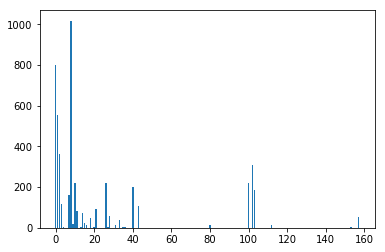

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
num = counter.keys()
value = counter.values()
plt.bar(num,value)

In [22]:
def filter_file(path,filter_contents):
    filter_file = open(path,'r')
    for line in filter_file.readlines():
        if line == None:
            break
        elif line == '':
            continue
        else:
            line = line.replace('\r','')
            line = line.replace('\n','')
            filter_contents[line] = line
    filter_file.close()
    
def vocabSet(path,vocabset):
    dirs = os.listdir(path)
    print(len(dirs))
    count = 0
    for dir in dirs:
        #print dir
        vocabset[dir] = Vocab(path + '/'+ dir)
        count +=1 
        #print count

def get_max_index(tree, max_index):
    max = int(max_index)
    if int(tree.index) > max:
        max = int(tree.index)
    for i in xrange(tree.num_children):
        max = get_max_index(tree.children[i],max)
    return max

def get_node(tree, index):
    node = tree
    if int(tree.index) == int(index):
        return node
    else:
        for i in xrange(tree.num_children):
            node = get_node(tree.children[i], index)
            if int(node.index) == int(index):
                return node
            else:
                node = tree
                continue
        return node
    
def create_newTree(root,class_word):
    newNode = Tree()
    max_index = get_max_index(root,0)
    newNode.index = max_index + 1
    newNode.word = class_word
    newNode.gold_label = None
    newNode.node = None
    if root.node != -1:
        parentNode = get_node(root,root.node)
        parentNode.add_child(newNode)
        return root
    else:
        holeNode = Tree()
        holeNode.word = 'hole'
        holeNode.node = None
        holeNode.gold_label = None
        holeNode.index = max_index + 2
        newNode.add_child(holeNode)
        newNode.add_child(root)
        newNode.gold_label = root.gold_label
        newNode.node = newNode.index
        root.gold_label = None
        root.node = None
        return newNode

In [23]:
filter_contents = {}
filter_file('data/filter.txt',filter_contents)
print('filter completed!')
vocabset = {}
vocabSet('data/classVocabulary',vocabset)

#checkpoint_path = 'data/method_model_500/treelstm_method_model_500-9'
checkpoint_path = 'data/class_model_another_500/treelstm_class_model_more_500-4'
checkpoint_path2 = 'data/treelstm_method_model_500-9'
dev_data = data_set
len(dev_data)

filter completed!
42174


30000

In [57]:
correct

262

In [24]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x),axis=0)

In [25]:
def get_batch(data,batchsize):
    n_batch = len(data)/batchsize
    for i in range(n_batch):
        yield data[i*batchsize:(i+1)*batchsize]

In [26]:
import copy

tf.reset_default_graph()
learning_rate = 0.01
keep_prob_now = 0.75
batch_size = 256
epoch = 10
num_gpus = 1
embedding_learning_rate_factor = 0.1
keep_prob_ph = tf.placeholder_with_default(1.0,[])

In [27]:
# 合并2，预测输入tree的class及具体method名称
def test_prediction2(batch,number):
    print('Create the model...')
    
    tf.reset_default_graph()
    word_embedding = create_embedding(weight_matrix=weight_matrix)
    compiler, metrics = create_model(word_embedding=word_embedding,NUM_CLASS=42237,lstm_num_units=150,keep_prob=keep_prob_now,vocab=vocab)

    saver = tf.train.Saver()

    print('class prediction...')
    with tf.Session() as sess:

        saver.restore(sess,checkpoint_path)

        class_output = sess.run(compiler.output_tensors,compiler.build_feed_dict(batch))
        logits = class_output[2]

        class_top_5 = sess.run(tf.nn.top_k(logits,5))

        # top-5的编号[batchsize,5]
        class_top_5_indices = class_top_5.indices

        output_class = []
        batch_newTrees = []
        # batchsize维度
        for i in range(len(class_top_5_indices)):
            # top-5维度
            words = []
            probs = []
            newTrees = []
            newTree_is_stop = []
            for index in class_top_5_indices[i]:
                # 取出第i个输入得到的第index个word和prob
                word = vocab2.token(index)
                prob = logits[i][index]
                words.append(word)
                probs.append(prob)

                copy_tree = copy.deepcopy(batch[i])
                newTree = create_newTree(copy_tree,word)
                newTrees.append(newTree)

                if filter_contents.get(word) == None and word != '--':
                    newTree_is_stop.append(0)            
                else:
                    newTree_is_stop.append(1)

            # 对top-5的输出执行softmax操作
            probs = softmax(probs)

            # output_class是class判断模型的输出，格式为(batchsize,(newTree,prob,is_stop)*5)
            output_class.extend(zip(newTrees,probs,words,newTree_is_stop))
            batch_newTrees.extend(newTrees)

        # 输出batch_size的class预测结果
        #print(output_class)

        print('prediction completed!')      

    tf.reset_default_graph()

    print('Create method model')

    word_embedding = create_embedding(weight_matrix=weight_matrix)
    compiler2, metrics2 = create_model(word_embedding=word_embedding,NUM_CLASS=1611,
                                     lstm_num_units=150,keep_prob=keep_prob_now,vocab=vocab)
    saver2 = tf.train.Saver()    

    print('method predeciton...')
    with tf.Session() as sess:

        saver2.restore(sess,checkpoint_path2)

        correct = 0

        # 调用method模型
        method_tuple_top_5 = []

        # 批量获得method模型输出
        method_output = sess.run(compiler2.output_tensors,compiler2.build_feed_dict(batch_newTrees))

        # 获得method预测，格式为[n*5,1611]
        method_logits = method_output[2]

        # 批量获得top-5的概率和编号，格式为[n*5,5]
        method_top_5 = sess.run(tf.nn.top_k(method_logits,5))
        method_top_5_values = sess.run(tf.nn.softmax(method_top_5.values.tolist()))
        method_top_5_indices = method_top_5.indices   

        #print(method_top_5_values)
        #print(method_top_5_indices)

        # 对n*5条tuple判断和计算综合概率
        batch_method_list = []
        for num,(newTree,prob,class_word,is_stop) in enumerate(output_class):
            method_list = []
            # 对class是非终止word的情况，计算class和method的综合概率
            if is_stop == 0:
                methodVocab = vocabset[class_word+'.txt']
                method_list_temp = [methodVocab.token(index) for index in method_top_5_indices[num]]

                method_prob_temp = [prob*method_prob for method_prob in method_top_5_values[num]]
                method_list.extend(zip(method_list_temp,method_prob_temp))
                #if i == 1:
                #    print(len(method_list_temp))
                #    print(len(method_list))

            # 对class是中止word的情况，直接使用classword和prob
            else:
                method_list.append((class_word,prob))
            # 将每个tuple的判断和概率添加到list中，格式为[n*5,5 or 1]
            batch_method_list.append(method_list)

        ans_method_prob = []
        for i in range(len(batch)):
            method_prob_each_tree = []
            pred_list = batch_method_list[i*5:(i+1)*5]
            for each_list in pred_list:
                method_prob_each_tree.extend(each_list)
            method_list_top_5 = sorted(method_prob_each_tree,key=lambda x:x[1],reverse=True)[:5]
            ans_method_prob.append(method_list_top_5)
            method_names = [name for name,method_prob in method_list_top_5]
            if predictions[i+512*number] in method_names[:1]:
                correct+=1
                
        print('correct: ',correct)
        return correct,len(batch)


In [28]:
# 合并3，预测输入tree的class及method编号
def test_prediction3(batch,number):
    print('Create the model...')
    
    tf.reset_default_graph()
    word_embedding = create_embedding(weight_matrix=weight_matrix)
    compiler, metrics = create_model(word_embedding=word_embedding,NUM_CLASS=42237,lstm_num_units=150,keep_prob=keep_prob_now,vocab=vocab)

    saver = tf.train.Saver()

    print('class prediction...')
    with tf.Session() as sess:

        saver.restore(sess,checkpoint_path)

        class_output = sess.run(compiler.output_tensors,compiler.build_feed_dict(batch))
        logits = class_output[2]

        class_top_5 = sess.run(tf.nn.top_k(logits,5))

        # top-5的编号[batchsize,5]
        class_top_5_indices = class_top_5.indices

        output_class = []
        batch_newTrees = []
        # batchsize维度
        for i in range(len(class_top_5_indices)):
            # top-5维度
            words = []
            nums = []
            probs = []
            newTrees = []
            newTree_is_stop = []
            for index in class_top_5_indices[i]:
                # 取出第i个输入得到的第index个word和prob
                word = vocab2.token(index)
                num = index
                prob = logits[i][index]
                words.append(word)
                probs.append(prob)
                nums.append(num)

                copy_tree = copy.deepcopy(batch[i])
                newTree = create_newTree(copy_tree,word)
                newTrees.append(newTree)

                if filter_contents.get(word) == None and word != '--':
                    newTree_is_stop.append(0)            
                else:
                    newTree_is_stop.append(1)

            # 对top-5的输出执行softmax操作
            probs = softmax(probs)

            # output_class是class判断模型的输出，格式为(batchsize,(newTree,prob,is_stop)*5)
            output_class.extend(zip(newTrees,probs,words,nums,newTree_is_stop))
            batch_newTrees.extend(newTrees)

        # 输出batch_size的class预测结果
        #print(output_class)

        print('prediction completed!')      

    tf.reset_default_graph()

    print('Create method model')

    word_embedding = create_embedding(weight_matrix=weight_matrix)
    compiler2, metrics2 = create_model(word_embedding=word_embedding,NUM_CLASS=1611,
                                     lstm_num_units=150,keep_prob=keep_prob_now,vocab=vocab)
    saver2 = tf.train.Saver()    

    print('method predeciton...')
    with tf.Session() as sess:

        saver2.restore(sess,checkpoint_path2)

        correct = {'top-1':0,'top-2':0,'top-3':0,'top-4':0,'top-5':0,'top-10':0}

        # 调用method模型
        method_tuple_top_5 = []

        # 批量获得method模型输出
        method_output = sess.run(compiler2.output_tensors,compiler2.build_feed_dict(batch_newTrees))

        # 获得method预测，格式为[n*5,1611]
        method_logits = method_output[2]

        # 批量获得top-5的概率和编号，格式为[n*5,5]
        method_top_5 = sess.run(tf.nn.top_k(method_logits,5))
        method_top_5_values = sess.run(tf.nn.softmax(method_top_5.values.tolist()))
        method_top_5_indices = method_top_5.indices   

        #print(method_top_5_values)
        #print(method_top_5_indices)

        # 对n*5条tuple判断和计算综合概率
        batch_method_list = []
        for num,(newTree,prob,class_word,class_num,is_stop) in enumerate(output_class):
            method_list = []
            # 对class是非终止word的情况，计算class和method的综合概率
            if is_stop == 0:
                #methodVocab = vocabset[class_word+'.txt']
                method_list_temp = [index for index in method_top_5_indices[num]]  
                method_prob_temp = [prob*method_prob for method_prob in method_top_5_values[num]]
                method_list.extend(zip(method_list_temp,method_prob_temp))
                #if i == 1:
                #    print(len(method_list_temp))
                #    print(len(method_list))

            # 对class是中止word的情况，直接使用classword和prob
            else:
                method_list.append((class_num,prob))
            # 将每个tuple的判断和概率添加到list中，格式为[n*5,5 or 1]
            batch_method_list.append(method_list)

        #print(batch_method_list)
        ans_method_prob = []
        for i in range(len(batch)):
            method_prob_each_tree = []
            pred_list = batch_method_list[i*5:(i+1)*5]
            for each_list in pred_list:
                method_prob_each_tree.extend(each_list)
            method_list_top_10 = sorted(method_prob_each_tree,key=lambda x:x[1],reverse=True)[:10]
            ans_method_prob.append(method_list_top_10)
            method_nums = [num for num,method_prob in method_list_top_10]
            if batch[i].gold_label in method_nums[:1]:
                correct['top-1'] += 1
            if batch[i].gold_label in method_nums[:2]:
                correct['top-2'] += 1
            if batch[i].gold_label in method_nums[:3]:
                correct['top-3'] += 1
            if batch[i].gold_label in method_nums[:4]:
                correct['top-4'] += 1
            if batch[i].gold_label in method_nums[:5]:
                correct['top-5'] += 1
            if batch[i].gold_label in method_nums[:10]:
                correct['top-10'] += 1
            #print((batch[i].gold_label,method_nums[:1]))
                
        print('top-1: %d, top-2: %d, top-3: %d, top-4: %d, top-5: %d, top-10: %d' % (correct['top-1'],correct['top-2'],
                                                                                     correct['top-3'],correct['top-4'],
                                                                                     correct['top-5'],correct['top-10']))
        return correct,len(batch)



In [49]:
from __future__ import print_function
correct_all = {'top-1':0,'top-2':0,'top-3':0,'top-4':0,'top-5':0,'top-10':0}
num_all = 0
for num,batch in enumerate(get_batch(data_set,512)):
    correct,num = test_prediction3(batch,num)
    correct_all['top-1'] += correct['top-1']
    correct_all['top-2'] += correct['top-2']
    correct_all['top-3'] += correct['top-3']
    correct_all['top-4'] += correct['top-4']
    correct_all['top-5'] += correct['top-5']
    correct_all['top-10'] += correct['top-10']
    num_all+=num

print('top-1: %.2f%%, top-2: %.2f%%, top-3: %.2f%%, top-4: %.2f%%, top-5: %.2f%%, top-10: %.2f%%' % 
      (correct_all['top-1']/float(num_all)*100,correct_all['top-2']/float(num_all)*100,correct_all['top-3']/float(num_all)*100,
      correct_all['top-4']/float(num_all)*100,correct_all['top-5']/float(num_all)*100,correct_all['top-10']/float(num_all)*100))

Create the model...
Create completed!
class prediction...
prediction completed!
Create method model
Create completed!
method predeciton...
top-1: 255, top-2: 320, top-3: 363, top-4: 389, top-5: 401, top-10: 412
Create the model...
Create completed!
class prediction...
prediction completed!
Create method model
Create completed!
method predeciton...
top-1: 221, top-2: 270, top-3: 305, top-4: 338, top-5: 358, top-10: 390
Create the model...
Create completed!
class prediction...
prediction completed!
Create method model
Create completed!
method predeciton...
top-1: 187, top-2: 240, top-3: 277, top-4: 307, top-5: 334, top-10: 368
Create the model...
Create completed!
class prediction...
prediction completed!
Create method model
Create completed!
method predeciton...
top-1: 300, top-2: 379, top-3: 426, top-4: 439, top-5: 449, top-10: 480
Create the model...
Create completed!
class prediction...
prediction completed!
Create method model
Create completed!
method predeciton...
top-1: 271, top-2